In [1]:
# 📥 1.1 - Imports and Setup

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers

# Seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Paths
base_dir = r'C:\Users\avina\OneDrive\Desktop\oral_cancer'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Config
img_size = (224, 224)
input_shape = (*img_size, 3)
batch_size = 32
class_names = ['Normal', 'OSCC']

print("✅ 1.1 Done")


✅ 1.1 Done


In [3]:
# 🧼 1.2 - Preprocessing & Generators

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=True
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

print("✅ 1.2 Done")


Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
✅ 1.2 Done


In [5]:
# 🧠 1.3 - Build ResNet101 Model

base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze base initially

# Build head
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.03))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()
print("✅ 1.3 Done")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [7]:
# 🚀 1.4 - Train in 2 Phases

checkpoint_path = os.path.join(base_dir, "resnet101_best_model.h5")

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

# Phase 1: Train head only
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# Phase 2: Fine-tune ResNet
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# Save final model
model.save(os.path.join(base_dir, "resnet101_final_model.h5"))
print("✅ 1.4 Done: Trained & fine-tuned")


Epoch 1/50
155/155 [==============================] - 356s 2s/step - loss: 26.2613 - accuracy: 0.6288 - precision: 0.6288 - recall: 0.6288 - val_loss: 23.0865 - val_accuracy: 0.6917 - val_precision: 0.6917 - val_recall: 0.6917 - lr: 1.0000e-04
Epoch 2/50
155/155 [==============================] - 3300s 21s/step - loss: 20.9178 - accuracy: 0.6989 - precision: 0.6989 - recall: 0.6989 - val_loss: 18.5414 - val_accuracy: 0.8167 - val_precision: 0.8167 - val_recall: 0.8167 - lr: 1.0000e-04
Epoch 3/50
155/155 [==============================] - 348s 2s/step - loss: 16.9793 - accuracy: 0.7315 - precision: 0.7315 - recall: 0.7315 - val_loss: 15.2705 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000 - lr: 1.0000e-04
Epoch 4/50
155/155 [==============================] - 2084s 14s/step - loss: 13.9862 - accuracy: 0.7483 - precision: 0.7483 - recall: 0.7483 - val_loss: 12.6107 - val_accuracy: 0.8333 - val_precision: 0.8333 - val_recall: 0.8333 - lr: 1.0000e-04
Epoch 5/50
155/155 [

Test Accuracy: 0.9286 | Precision: 0.9286 | Recall: 0.9286


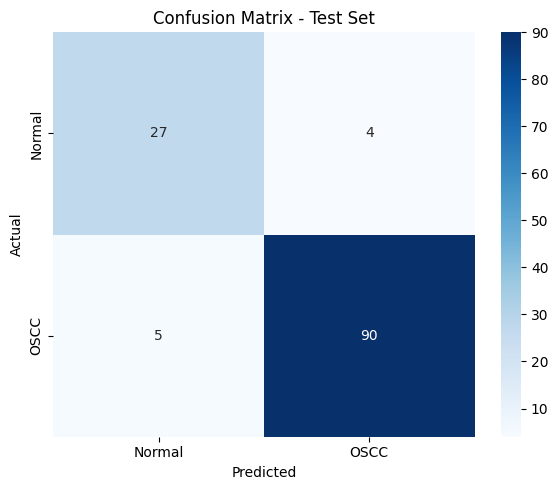

Classification Report:
              precision    recall  f1-score   support

      Normal       0.84      0.87      0.86        31
        OSCC       0.96      0.95      0.95        95

    accuracy                           0.93       126
   macro avg       0.90      0.91      0.90       126
weighted avg       0.93      0.93      0.93       126



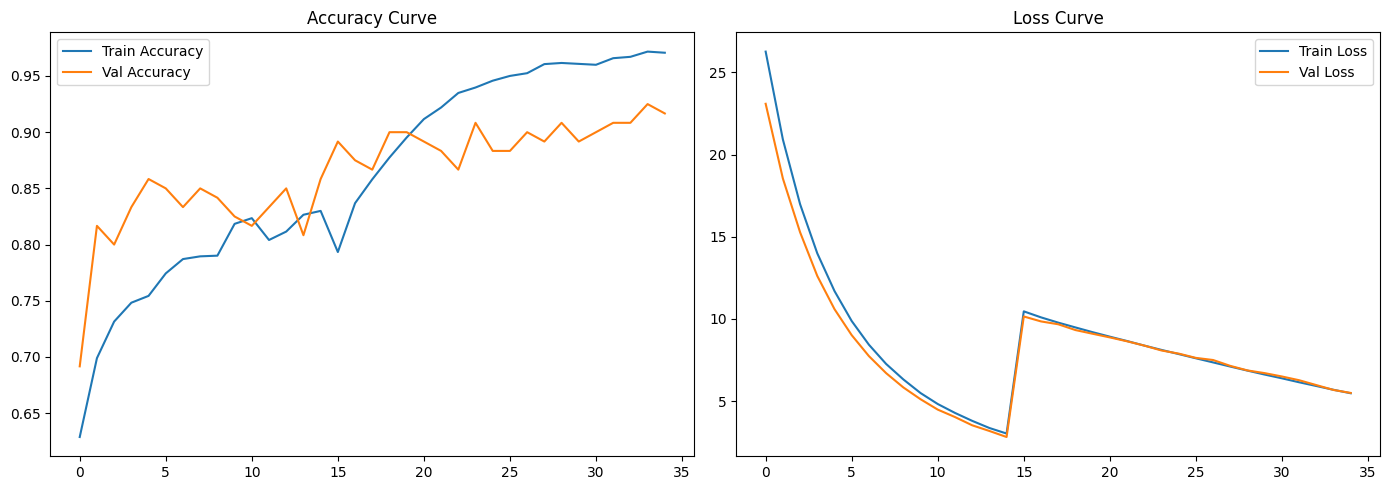

In [9]:
# 📈 1.5 - Evaluation

model = load_model(os.path.join(base_dir, "resnet101_best_model.h5"))
test_gen.reset()
loss, acc, prec, rec = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")

# Predictions
y_pred = np.argmax(model.predict(test_gen, verbose=0), axis=1)
y_true = test_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Curves
def plot_curves(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']
    epochs = range(len(acc))
    
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy Curve")
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.legend()
    plt.title("Loss Curve")
    plt.tight_layout()
    plt.show()

plot_curves(history1, history2)


In [11]:
# 🔍 1.6 - Predict single image

def predict_image(image_path):
    model = load_model(os.path.join(base_dir, "resnet101_best_model.h5"))
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found!")
        return
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_img = preprocess_input(np.expand_dims(img, axis=0))
    
    pred = model.predict(input_img, verbose=0)
    class_idx = np.argmax(pred)
    confidence = pred[0][class_idx] * 100

    plt.imshow(img)
    plt.title(f"Prediction: {class_names[class_idx]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"🧠 Predicted: {class_names[class_idx]} ({confidence:.2f}%)")


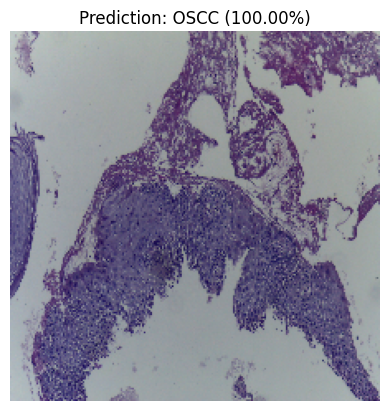

🧠 Predicted: OSCC (100.00%)


In [13]:
# 🔍 Example use:
predict_image(r"C:\Users\avina\OneDrive\Desktop\oral_cancer\test\OSCC\OSCC_100x_101.jpg")

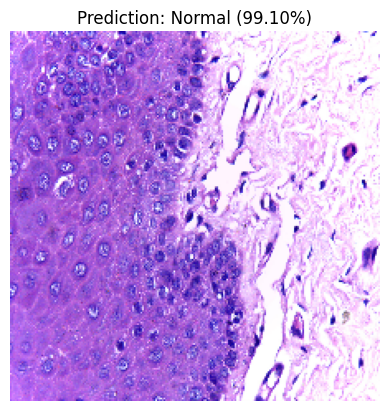

🧠 Predicted: Normal (99.10%)


In [15]:
predict_image(r"C:\Users\avina\OneDrive\Desktop\oral_cancer\test\Normal\Normal_400x_155.jpg")

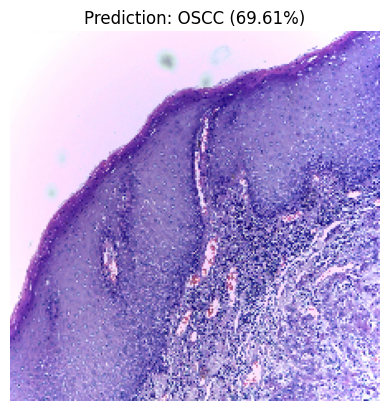

🧠 Predicted: OSCC (69.61%)


In [17]:
predict_image(r"C:\Users\avina\OneDrive\Desktop\oral_cancer\val\OSCC\OSCC_100x_346.jpg")

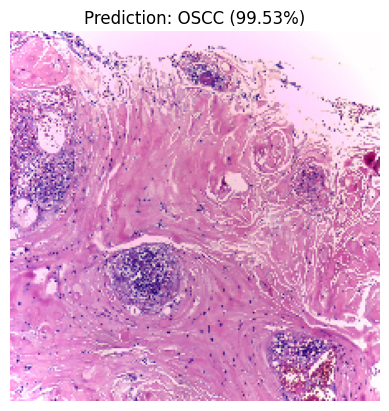

🧠 Predicted: OSCC (99.53%)


In [23]:
predict_image(r"C:\Users\avina\OneDrive\Desktop\oral_cancer\test\OSCC\OSCC_100x_358.jpg")